In [1]:
import yfinance as yf
import pandas as pd

# Define the tickers and the date range
tickers = ['TSLA', 'BND', 'SPY']
start_date = '2015-07-01'
end_date = '2025-07-31'

# 1. Extract historical financial data
try:
    data = yf.download(tickers, start=start_date, end=end_date)
    print("✅ Data downloaded successfully!")
    print(data.head())
    
    # 2. Check for missing values
    print("\n--- Initial Check for Missing Values ---")
    print(data.isnull().sum())

    # 3. Handle missing values using forward-fill
    # This is a good method for financial data as it assumes the price on a 
    # non-trading day (like a holiday) is the same as the last trading day.
    data.ffill(inplace=True)

    # 4. Verify that missing values are handled
    print("\n--- Verification after Handling Missing Values ---")
    print(data.isnull().sum().sum()) # .sum().sum() gives a single number for all NaNs
    print("✅ Data cleaning complete.")

except Exception as e:
    print(f"❌ An error occurred: {e}")

/tmp/ipykernel_215012/4026018916.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)
[*********************100%***********************]  3 of 3 completed

✅ Data downloaded successfully!
Price           Close                              High              \
Ticker            BND         SPY       TSLA        BND         SPY   
Date                                                                  
2015-07-01  60.816715  174.917084  17.943333  60.914441  175.363859   
2015-07-02  60.967110  174.756958  18.667999  61.027251  175.566219   
2015-07-06  61.177586  174.259552  18.648001  61.222695  175.043511   
2015-07-07  61.237690  175.355469  17.858667  61.470731  175.481910   
2015-07-08  61.410629  172.413498  16.997334  61.463252  174.293327   

Price                        Low                              Open  \
Ticker           TSLA        BND         SPY       TSLA        BND   
Date                                                                 
2015-07-01  18.174667  60.764093  174.124686  17.856667  60.794164   
2015-07-02  18.830000  60.937039  174.335471  18.220667  60.937039   
2015-07-06  18.779333  61.057308  173.256411  18.

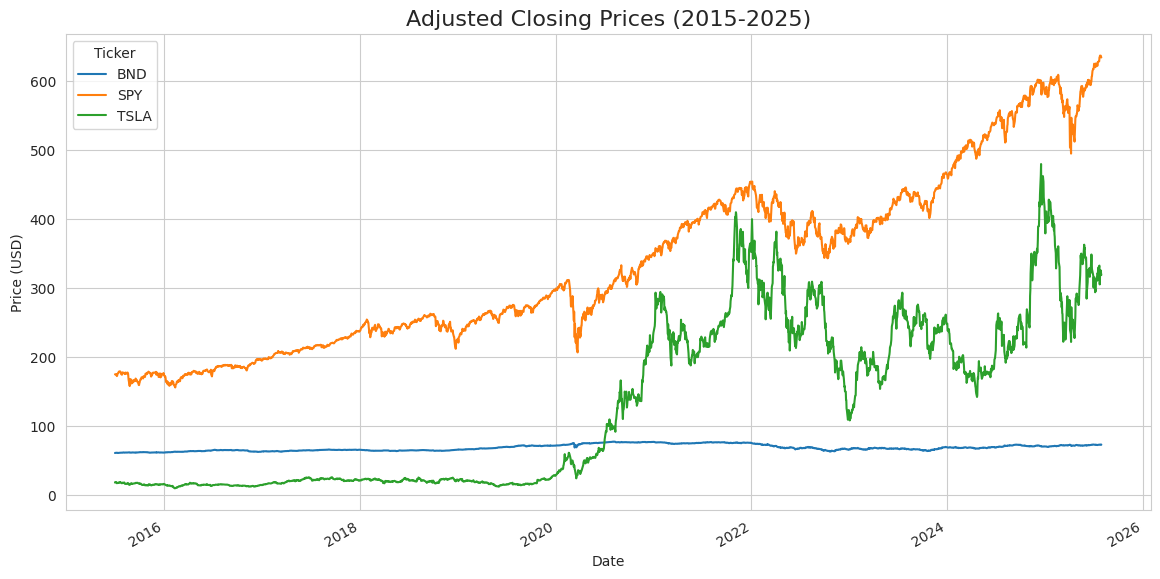

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a style for the plots
sns.set_style('whitegrid')

# Plot the Adjusted Close prices
data['Close'].plot(figsize=(14, 7))

plt.title('Adjusted Closing Prices (2015-2025)', fontsize=16)
plt.ylabel('Price (USD)')
plt.xlabel('Date')
plt.legend(title='Ticker')
plt.show()

In [3]:
from statsmodels.tsa.stattools import adfuller

# We will use the 'Close' column as you specified
close_prices = data['Close']
daily_returns_close = close_prices.pct_change().dropna()

# Function to run and interpret the ADF test
def run_adf_test(series, name=''):
    result = adfuller(series)
    print(f'--- ADF Test Results for {name} ---')
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    if result[1] <= 0.05:
        print("Conclusion: Reject the null hypothesis. Data is likely stationary.")
    else:
        print("Conclusion: Fail to reject the null hypothesis. Data is likely non-stationary.")
    print('-' * 40)

# Run the test on TSLA's Close Price and Daily Returns
run_adf_test(close_prices['TSLA'], name='TSLA Close Price')
run_adf_test(daily_returns_close['TSLA'], name='TSLA Daily Returns')

--- ADF Test Results for TSLA Close Price ---
ADF Statistic: -1.4189
p-value: 0.5732
Conclusion: Fail to reject the null hypothesis. Data is likely non-stationary.
----------------------------------------
--- ADF Test Results for TSLA Daily Returns ---
ADF Statistic: -34.6811
p-value: 0.0000
Conclusion: Reject the null hypothesis. Data is likely stationary.
----------------------------------------


In [4]:
import numpy as np

# --- 1. Value at Risk (VaR) ---
# We'll calculate the 95% VaR, which corresponds to the 5th percentile of daily returns.
confidence_level = 0.05
var_95 = daily_returns_close.quantile(confidence_level)

print(f"--- 95% Value at Risk (VaR) ---")
print("This means on 95% of days, the loss is not expected to exceed:")
print(var_95.apply(lambda x: f"{x:.2%}"))


# --- 2. Annualized Sharpe Ratio ---
# We assume a risk-free rate of 0 for simplicity.
# We multiply by the square root of 252 (trading days in a year) to annualize.
risk_free_rate = 0
mean_returns = daily_returns_close.mean()
std_dev = daily_returns_close.std()

sharpe_ratio = (mean_returns - risk_free_rate) / std_dev
annualized_sharpe_ratio = sharpe_ratio * np.sqrt(252)

print("\n--- Annualized Sharpe Ratio ---")
print("A higher value indicates better historical risk-adjusted returns.")
print(annualized_sharpe_ratio.round(2))

--- 95% Value at Risk (VaR) ---
This means on 95% of days, the loss is not expected to exceed:
Ticker
BND     -0.49%
SPY     -1.72%
TSLA    -5.47%
Name: 0.05, dtype: object

--- Annualized Sharpe Ratio ---
A higher value indicates better historical risk-adjusted returns.
Ticker
BND     0.36
SPY     0.79
TSLA    0.78
dtype: float64


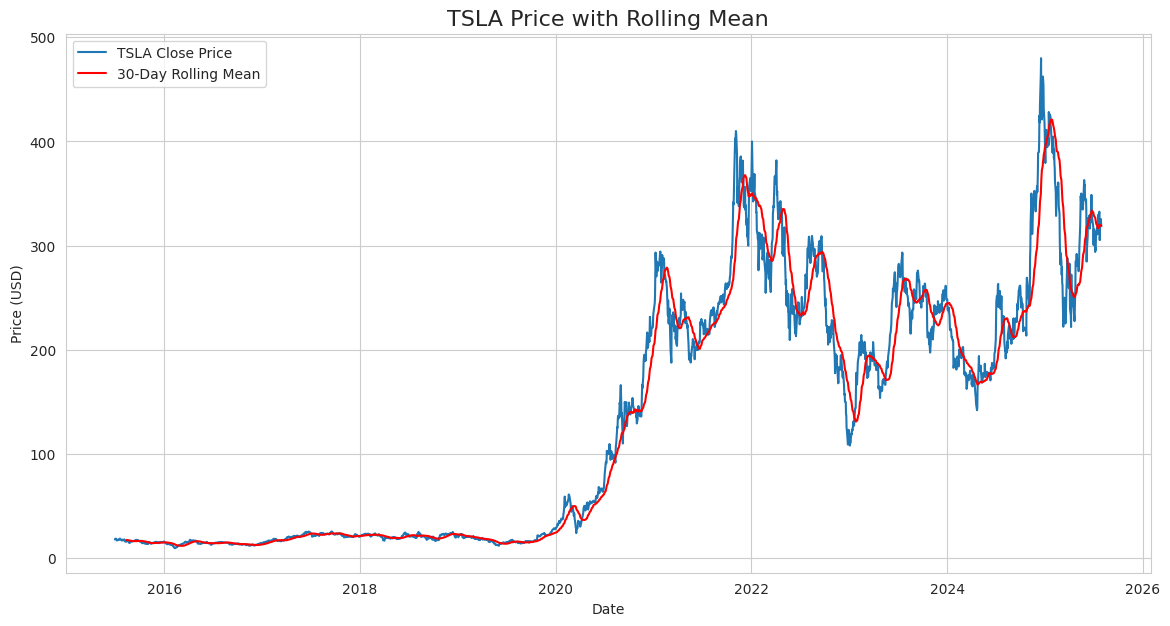

In [6]:
# Set the window for the rolling statistics (e.g., 30 days)
rolling_window = 30

# Calculate rolling mean and standard deviation for TSLA
rolling_mean_tsla = close_prices['TSLA'].rolling(window=rolling_window).mean()
rolling_std_tsla = close_prices['TSLA'].rolling(window=rolling_window).std()

# Plot the original price and the rolling mean
plt.figure(figsize=(14, 7))
plt.plot(close_prices['TSLA'], label='TSLA Close Price')
plt.plot(rolling_mean_tsla, label=f'{rolling_window}-Day Rolling Mean', color='red')
plt.title('TSLA Price with Rolling Mean', fontsize=16)
plt.ylabel('Price (USD)')
plt.xlabel('Date')
plt.legend()
plt.show()


In [7]:
from statsmodels.tsa.stattools import adfuller

# Function to run and interpret the ADF test
def run_adf_test(series, name=''):
    result = adfuller(series)
    print(f'--- ADF Test Results for {name} ---')
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    if result[1] <= 0.05:
        print("Conclusion: Reject the null hypothesis. Data is likely stationary.")
    else:
        print("Conclusion: Fail to reject the null hypothesis. Data is likely non-stationary.")
    print('-' * 40)

# Assuming 'close_prices' and 'daily_returns' are from the previous steps
# Test 1: On the non-stationary closing price
run_adf_test(close_prices['TSLA'].dropna(), name='TSLA Close Price')

# Test 2: On the daily returns
run_adf_test(daily_returns_close['TSLA'].dropna(), name='TSLA Daily Returns')


--- ADF Test Results for TSLA Close Price ---
ADF Statistic: -1.4189
p-value: 0.5732
Conclusion: Fail to reject the null hypothesis. Data is likely non-stationary.
----------------------------------------
--- ADF Test Results for TSLA Daily Returns ---
ADF Statistic: -34.6811
p-value: 0.0000
Conclusion: Reject the null hypothesis. Data is likely stationary.
----------------------------------------


In [8]:
import numpy as np

# --- Value at Risk (VaR) ---
# Calculate 95% VaR for each asset
confidence_level = 0.05
var_95 = daily_returns_close.quantile(confidence_level)

print(f"--- 95% Value at Risk (VaR) ---")
print("This means on 5% of days, we can expect a loss of at least:")
print(var_95.apply(lambda x: f"{x:.2%}"))

# --- Sharpe Ratio ---
# Assuming a risk-free rate of 0 for simplicity
# The number of trading days in a year is typically 252
risk_free_rate = 0
mean_returns = daily_returns_close.mean()
std_dev = daily_returns_close.std()

sharpe_ratio = (mean_returns - risk_free_rate) / std_dev
annualized_sharpe_ratio = sharpe_ratio * np.sqrt(252)

print("\n--- Annualized Sharpe Ratio ---")
print("A higher value indicates better risk-adjusted returns.")
print(annualized_sharpe_ratio.round(2))

--- 95% Value at Risk (VaR) ---
This means on 5% of days, we can expect a loss of at least:
Ticker
BND     -0.49%
SPY     -1.72%
TSLA    -5.47%
Name: 0.05, dtype: object

--- Annualized Sharpe Ratio ---
A higher value indicates better risk-adjusted returns.
Ticker
BND     0.36
SPY     0.79
TSLA    0.78
dtype: float64


In [9]:
import os

# Create the processed data directory if it doesn't exist
output_dir = '../data/processed'
os.makedirs(output_dir, exist_ok=True)

# Define the file paths
full_data_path = os.path.join(output_dir, 'full_ohlcv_data.csv')
returns_path = os.path.join(output_dir, 'daily_returns.csv')

# Save the DataFrames to CSV files
data.to_csv(full_data_path)
daily_returns_close.to_csv(returns_path)

print(f"✅ Full dataset saved to: {full_data_path}")
print(f"✅ Daily returns saved to: {returns_path}")

✅ Full dataset saved to: ../data/processed/full_ohlcv_data.csv
✅ Daily returns saved to: ../data/processed/daily_returns.csv
